In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from matplotlib.ticker import FormatStrFormatter

In [38]:
def fetch_ipi_api():
    url = "https://api.data.gov.my/data-catalogue?id=lfs_month"
    response = requests.get(url)
    response.raise_for_status()
    records = response.json()
    return records

def build_df_from_api():
    raw_data = fetch_ipi_api()
    df = pd.DataFrame(raw_data)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['lf_unemployed'] = pd.to_numeric(df['lf_unemployed'], errors='coerce')  
    df['u_rate'] = pd.to_numeric(df['u_rate'], errors='coerce')
    df = df.sort_values('date').dropna(subset=['date', 'u_rate']).reset_index(drop=True)
    return df[['date', 'lf_unemployed', 'u_rate']]

In [39]:
# build the dataframe

df = build_df_from_api()

In [40]:
# Impute the latest datapoints
newdata = pd.DataFrame({
    'date': [pd.Timestamp('2025-05-01')],
    'lf_unemployed': [522.9],
    'u_rate': [3.0]
})

# Concatenate and re-sort
df = pd.concat([df, newdata], ignore_index=True)
df = df.sort_values('date').reset_index(drop=True)

In [41]:
df['u_rate'] = df['u_rate'].round(1)

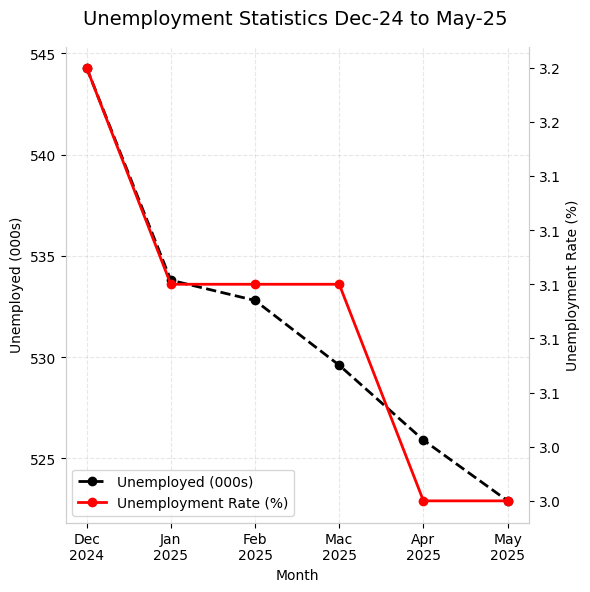

In [42]:
# Filter for the last 5 months
df_filter = df.sort_values('date').tail(6).copy()

# Prepare x-axis labels as "Mon\nYYYY"
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mac', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
df_filter['label'] = df_filter['date'].apply(lambda x: f"{month_map[x.month]}\n{x.year}")

fig, ax1 = plt.subplots(figsize=(6, 6))

# Plot lf_unemployed on ax1 (left y-axis)
color1 = 'black'
ax1.set_xlabel('Month')
ax1.set_ylabel('Unemployed (000s)', color=color1)
ax1.plot(df_filter['label'], df_filter['lf_unemployed'], color=color1, marker='o', linewidth=2, label='Unemployed (000s)', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color1)

# Set spine colors for ax1
for spine in ax1.spines.values():
    spine.set_edgecolor('#cecece')
ax1.spines['top'].set_color('white')


# Create a second y-axis for u_rate
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('Unemployment Rate (%)', color=color1)
ax2.plot(df_filter['label'], df_filter['u_rate'], color=color2, marker='o', linewidth=2, label='Unemployment Rate (%)', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color1)

# Set secondary y-axis ticks to 1 decimal point
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

for spine in ax2.spines.values():
    spine.set_edgecolor('#cecece')
ax2.spines['top'].set_color('white')

# Set title
fig.suptitle('Unemployment Statistics Dec-24 to May-25', fontsize=14, color='black')

# Add grid to ax1
ax1.grid(True, alpha=0.3, linestyle='--')

# Add legends for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower left')

plt.tight_layout()
plt.show()